## **Setting Things Up**

**1 If you haven't already, please hit :**

`File > Save a Copy in Drive`

**to copy this notebook to your Google drive, and work on a copy. If you don't do this, your changes won't be saved!**


**2 In order to use a GPU with your notebook, select :**

`Runtime > Change runtime type`

**menu, and then set the hardware accelerator dropdown to GPU. This can significantly speed up the training process.**

**3 In order to have enough memory with your notebook, select :**

`Runtime > Change runtime type`

**menu, and then select High-RAM in the Runtime shape dropdown.**

To facilitate your initial progress, we have included a ready-to-use code on Google Colab for this problem. It allows you to get started immediately. Additionally, if you prefer not to use Google Colab and prefer setting up your own programming environment or employing alternative methods, the provided files and code will still be valuable.

**PS:You need manually install the `tensorflow_text` and `tf-models-official` libraries**


**PS:You also need manually load pretrained Bert model weights `bert_en_uncased_preprocess_3` and `small_bert_bert_en_uncased_L-4_H-512_A-8_2` into `model weight` folder. The Bert model weights can be found in our datasets.**

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jun 21 07:41:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    45W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 83.1 MB/s eta 0:00:00


In [ ]:
!pip install tf-models-official

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# -*-coding:utf8 -*-

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd

import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

from keras.optimizers import RMSprop, Adam, SGD
from keras.callbacks import LearningRateScheduler
from keras.applications.inception_v3 import InceptionV3
from keras import Model, Input, layers, regularizers
from keras.models import load_model
from keras import activations


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# change to your personal project address

%cd /content/drive/MyDrive/Colab Notebooks/Vehicle Rating Prediction

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Vehicle Rating Prediction


## **1 Data Processing**

In [ ]:
# train data shuffle index
num1 = 2055
idx1 = tf.range(num1)
idx1 = tf.random.shuffle(idx1)
# print(idx1)
# print(idx1[0])
with tf.compat.v1.Session():
    index1 = idx1.numpy()
print(index1.shape)
# print(index1[0])

# validation data shuffle index
num2 = 258
idx2 = tf.range(num2)
idx2 = tf.random.shuffle(idx2)
# print(idx2)
# print(idx2[0])
with tf.compat.v1.Session():
    index2 = idx2.numpy()
print(index2.shape)
# print(index2[0])

# test data shuffle index
num3 = 258
idx3 = tf.range(num3)
idx3 = tf.random.shuffle(idx3)
# print(idx3)
# print(idx3[0])
with tf.compat.v1.Session():
    index3 = idx3.numpy()
print(index3.shape)
# print(index3[0])

(2055,)
(258,)
(258,)


In [ ]:
var = "total score"
# var = "safety score"
# var = "performance score"
# var = "interior score"
# var = "critics score"

In [ ]:

# load the text data
var_name = 'data split ' + var

sketch1 = pd.read_csv('text_data.csv', encoding='latin1')
# print(sketch1.shape)
# print(sketch1)
# print(sketch1[var])
train_df = sketch1[sketch1[var_name] == 1]
val_df = sketch1[sketch1[var_name] == 2]
test_df = sketch1[sketch1[var_name] == 3]
# print(train_df.shape)
# print(train_df)

sketch2 = train_df.astype({"text": str})
text1 = list(sketch2['text'])

sketch3 = val_df.astype({"text": str})
text2 = list(sketch3['text'])

sketch4 = test_df.astype({"text": str})
text3 = list(sketch4['text'])


train_text = [text1[i] for i in index1]
x_train_text = tf.constant(train_text)

validation_text = [text2[i] for i in index2]
x_validation_text = tf.constant(validation_text)

test_text = [text3[i] for i in index3]
x_test_text = tf.constant(test_text)
# print(len(train_text))
# print(train_text[0])

y_value = var
y_train_origin = list(train_df[y_value])
y_train = np.array([y_train_origin[i] for i in index1])
y_val_origin = list(val_df[y_value])
y_val = np.array([y_val_origin[i] for i in index2])
y_test_origin = list(test_df[y_value])
y_test = np.array([y_test_origin[i] for i in index3])
# print(y_train.shape)
# print(y_train)
# print(y_val.shape)
# print(y_val)
# print(y_test.shape)
# print(y_test)


## **2 Construct Text Model**

In [ ]:
# bert model

epochs = 200
steps_per_epoch = 80
num_train_steps = steps_per_epoch * epochs

a = 0.05
num_warmup_steps = int(a * num_train_steps)
init_lr = 5e-5
optimizer = optimization.create_optimizer(init_lr=init_lr, num_train_steps=num_train_steps, num_warmup_steps=num_warmup_steps, optimizer_type='adamw')

text_input = Input(shape=(), dtype=tf.string, name='text')
preprocessing_layer = hub.KerasLayer("model weight/bert_en_uncased_preprocess_3", name='preprocessing')
encoder_inputs = preprocessing_layer(text_input)
encoder = hub.KerasLayer("model weight/small_bert_bert_en_uncased_L-4_H-512_A-8_2", trainable=True, name='BERT_encoder')
outputs = encoder(encoder_inputs)
net = outputs['pooled_output']
net = layers.Dropout(0.1, name='text_dropout_after_Bert')(net)
# last_second_layer = last2
net = layers.Dense(100, activation='relu', name='text_dense_last2')(net)
# net = layers.Dropout(0.1)(net)
out1y = layers.Dense(1, name='text_out1y')(net)
model = Model(text_input, out1y, name='Text_Model')

model.compile(optimizer=optimizer, loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mse', 'mae'])

model.summary()


Model: "Text_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                             

In [ ]:
epochs = 200
steps_per_epoch = 80
batch_size = 32

early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=20, monitor="val_loss", restore_best_weights=True, verbose=1)

In [ ]:
history = model.fit(
    x_train_text,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    steps_per_epoch=steps_per_epoch,
    validation_data=(x_validation_text, y_val),
    callbacks=[early_stopping_callback]
)

print(history)

Epoch 1/200
80/80 [==============================] - 18s 82ms/step - loss: 0.1456 - rmse: 0.3816 - mse: 0.1456 - mae: 0.3046 - val_loss: 0.0376 - val_rmse: 0.1940 - val_mse: 0.0376 - val_mae: 0.1535
Epoch 2/200
80/80 [==============================] - 6s 74ms/step - loss: 0.0740 - rmse: 0.2720 - mse: 0.0740 - mae: 0.2160 - val_loss: 0.0236 - val_rmse: 0.1538 - val_mse: 0.0236 - val_mae: 0.1242
Epoch 3/200
80/80 [==============================] - 6s 72ms/step - loss: 0.0428 - rmse: 0.2068 - mse: 0.0428 - mae: 0.1638 - val_loss: 0.0139 - val_rmse: 0.1181 - val_mse: 0.0139 - val_mae: 0.0926
Epoch 4/200
80/80 [==============================] - 6s 73ms/step - loss: 0.0297 - rmse: 0.1724 - mse: 0.0297 - mae: 0.1373 - val_loss: 0.0128 - val_rmse: 0.1131 - val_mse: 0.0128 - val_mae: 0.0905
Epoch 5/200
80/80 [==============================] - 6s 72ms/step - loss: 0.0215 - rmse: 0.1467 - mse: 0.0215 - mae: 0.1155 - val_loss: 0.0102 - val_rmse: 0.1010 - val_mse: 0.0102 - val_mae: 0.0772
Epoch 6/2

## **3 Model Evaluation and Results**

In [ ]:
test_loss, test_rmse, test_mse, test_mae  = model.evaluate(x_test_text, y_test, verbose=2)
validation_loss, validation_rmse, validation_mse, validation_mae = model.evaluate(x_validation_text, y_val, verbose=2)
train_loss, train_rmse, train_mse, train_mae = model.evaluate(x_train_text, y_train, verbose=2)

9/9 - 0s - loss: 0.0059 - rmse: 0.0771 - mse: 0.0059 - mae: 0.0577 - 425ms/epoch - 47ms/step
9/9 - 0s - loss: 0.0059 - rmse: 0.0769 - mse: 0.0059 - mae: 0.0577 - 422ms/epoch - 47ms/step
65/65 - 3s - loss: 4.9615e-04 - rmse: 0.0223 - mse: 4.9615e-04 - mae: 0.0174 - 3s/epoch - 48ms/step


In [ ]:
result = model.predict(x_test_text)
# print(result)
# print(result[0])

9/9 [==============================] - 1s 44ms/step


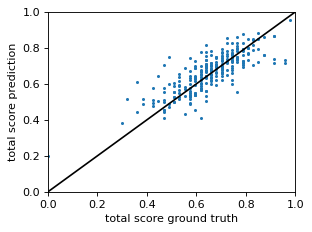

In [ ]:
figure(figsize=(4, 3), dpi=80)
plt.scatter(np.array(y_test), result, s=3)
# plt.legend()
x = [0, 1]
y = [0, 1]
plt.plot(x, y, color="black")
plt.xlabel(var + ' ground truth')
plt.ylabel(var + ' prediction')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.tight_layout()
plt.show()

# plot_history(history)


In [ ]:
from math import nan
test = np.array(y_test).T
# print(test)
predict = np.array(result).T

correlation_matrix = np.corrcoef(test, predict)
print(correlation_matrix)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

print (r_squared)

[[1.         0.79543965]
 [0.79543965 1.        ]]
0.6327242443289516


## **4 Store the Model & Train, Validation and Test Results**

In [ ]:
output = pd.DataFrame()
idx = 0
output.loc[idx, 'train_rmse'] = train_rmse
output.loc[idx, 'train_mse'] = train_mse
output.loc[idx, 'train_mae'] = train_mae

output.loc[idx, 'validation_rmse'] = validation_rmse
output.loc[idx, 'validation_mse'] = validation_mse
output.loc[idx, 'validation_mae'] = validation_mae

output.loc[idx, 'test_rmse'] = test_rmse
output.loc[idx, 'test_mse'] = test_mse
output.loc[idx, 'test_mae'] = test_mae

output.loc[idx, 'r^2'] = r_squared
pd.set_option('display.max_columns', None)
print(output)
output.to_csv('text_unimodal_value.csv')

In [ ]:
# store the model
# summarize the loaded model
model.summary()
# save the best performing model to file
model.save('model weight/' + var + '_Text.h5', include_optimizer=False)


Model: "Text_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                             

In [ ]:
# reload the model
model_name = 'model weight/' + var + '_Text.h5'
Bertmodel = tf.keras.models.load_model(model_name, custom_objects={'KerasLayer': hub.KerasLayer})
Bertmodel.summary()

result = Bertmodel.predict(x_test_text)

test = np.array(y_test).T
predict = np.array(result).T

correlation_matrix = np.corrcoef(test, predict)
print(correlation_matrix)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

print (r_squared)

In [ ]:
for layer in Bertmodel.layers:
    layer.trainable = True
    print(layer.name, layer)
Bert_weight = Bertmodel.layers[-1].get_weights()[0]
Bert_bias = Bertmodel.layers[-1].get_weights()[1]
print(Bert_weight)
print(len(Bert_weight))
print(Bert_bias)

In [ ]:
# try to get the output
layer_name = 'BERT_encoder'
layer_output_origin = model.get_layer(layer_name).output
# layer_output = layer_output_origin['pooled_output']
layer_output = layer_output_origin
print(layer_output)
print(layer_output['pooled_output'])